# Building network of collaborators between projects in WASM ecosystem. 

Contributors in a repo interact with one another via:
- co-committing
- reviewing each other's PRs
- messaging in the same PR thread
- messaging in the same issue thread

We have previously built and analyzed a graph representation of this and have
identified those individuals who are highly connected to other contributors in the same repo.

## Repo ecosystem collaboration network

Contributors are often participants in more than one repository at once. Likewise, groups of contributors might collaborate with one another in more than one repo at a time. 

Identifying meta-communities of contributors beyond the scope of an individual repo has implications in studying knowledge retention, project preeminence, and linchpin contributorship, among other things.

## Notebook premise

In this notebook, we'll build and annotate the collaboration network representation of the following projects:

- bytecodealliance/wasmtime
- wasmedge/wasmedge
- wasmerio/wasmer
- wavm/wavm


## Notebook Author
James Kunstle (jkunstle@redhat.com)

### Majority of utility + module code by: 
Maria Shevchuk (maria410@bu.edu)

# Required packages

In [1]:
# These are the required packages. Giving a 'requirements.txt' can be insufficient for 
# ipynb kernels sometimes, so I'd recommend uncommenting and running the below line if
# you don't have all dependencies.

%pip install sqlalchemy pandas psycopg2-binary networkx matplotlib scipy nbformat kaleido plotly


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
from data_utils.queries import fetch_data
from graph_utils.graph_helper import build_graph, find_threshold, apply_pagerank, draw_network
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import plotly.express as px
import colorsys
from IPython.display import Image

# Backend dynamic rendering. Will need to be changed for Linux machines.
plt.switch_backend('macosx')

## Merge networks

For each repo we're considering, we first build its own collaboration network. A collaboration network 
is a representation of inter-contributor interactions, modeled with contributors as 'nodes' and 
interactions as 'edges.' Edge weights are based on the kind of interactions two contributors have
had. 

We merge that collaboration network of one repo with the other collaboration networks created for other repos.

Some nodes will have the same identify between two repos- for these nodes, we re-ascribe a color from the
average of the node's two origin repos. We also make a note that the node appeared in more than one repo
previously, and take the union of all of it's existing edges in both networks.

The end product is a network with unique nodes, and each node is connected to all of the other nodes they've 
collaborated with in the past across all of the studied repos.

In [3]:
def build_ecosystem_graph(repos, start, end):
    # color the nodes of the graph based on the number of repos added above, interpolated over RGB space.
    valid_colors = [
        colorsys.hsv_to_rgb(hue, 1.0, 1.0) 
        for hue in list(np.linspace(start=0.05, stop=0.95, num=len(repos)))
    ]

    # scale rgb floats to 255 integer values
    valid_colors = [
        (int(255*r), int(255*g), int(255*b)) 
        for r, g, b in valid_colors 
    ]

    # placeholder variable for result
    ecosystem_g = None

    for i, (repo, org) in enumerate(repos):
        # download the data
        r_data = fetch_data(org, repo)
        print(f"got data for {repo}/{org}")

        # build the network for a single repo
        r_g = build_graph(r_data, 
                          start, 
                          end, 
                          cmt_weight=1.0, 
                          ism_weight=0.1, 
                          pr_weight=2.0, 
                          prm_weight=0.2
                        )
        print(f"built graph for {repo}/{org}")

        # enrich node with 'color' metadata
        nx.set_node_attributes(r_g, valid_colors[i], "color")
        nx.set_node_attributes(r_g, f"{org}/{repo}", "origin")
        print(f"set attribute for {repo}/{org}")

        if not ecosystem_g:
            ecosystem_g = r_g
        else:
            # combine the graphs
            combo_g = nx.compose(ecosystem_g, r_g)
            
            # When we combine the graphs, we have to average the color of the nodes that belong in both graphs.
            # in order to average an RGB channel, the true average is root((r1^2 + r2^2) / 2), which we do for every shared node.
            color_data = {
                n: 
                (
                    # r channel
                    np.sqrt((((r_g.nodes[n]['color'][0] ** 2) + (ecosystem_g.nodes[n]['color'][0] ** 2)) / 2)),
                    # g channel
                    np.sqrt((((r_g.nodes[n]['color'][1] ** 2) + (ecosystem_g.nodes[n]['color'][1] ** 2)) / 2)),
                    # b channel
                    np.sqrt((((r_g.nodes[n]['color'][2] ** 2) + (ecosystem_g.nodes[n]['color'][2] ** 2)) / 2))
                )
                for n in r_g.nodes & ecosystem_g.nodes
            }
            nx.set_node_attributes(combo_g, color_data, 'color')

            # track the repo/org pair source of a node. which repo/org pairs are they members of? 
            origin_data = {
                n:
                f"{ecosystem_g.nodes[n]['origin']}, {r_g.nodes[n]['origin']}"
                for n in r_g.nodes & ecosystem_g.nodes 
            }
            nx.set_node_attributes(combo_g, origin_data, 'origin')
            

            ecosystem_g = combo_g

    # set the node colors in the format that plotly wants, "rgb(r, g, b)"
    ecosystem_g_colors = [f"rgb{str(ecosystem_g.nodes[n]['color'])}" for n in ecosystem_g.nodes]

    return ecosystem_g, ecosystem_g_colors

## Explanation of above logic:

The goal of the above function is to combine the collaboration networks of the input repos, creating an 'ecosystem' network, with node-colorings corresponding to the repos that a node was associated with. The overarching pseudo-code is the following:

```
 // ecosystem network object
G = None

for repo in repolist:
    
    // network of repo
    g = build_network(repo)
    
    if G is None:
        G = g
    else:
        // merge the existing network with the 
        // new network
        G = combine_networks(G, g)

        // overlapping nodes
        common_nodes = union(G.nodes, g.nodes)

        for n in common_nodes:
            // take the running average color of node
            n.color = avg(G[n].color, g[n].color)

return G
```

## Build the visualization of an ecosystem-level collaboration network.

Arbitrarily starting in January 2017 and ending in September 2023, create the collaboration network of the following four repos.

In [4]:
# repo, org pairs
repos = [
    ("wasmtime", "bytecodealliance"),
    ("wasmedge", "wasmedge"),
    ("wasmer", "wasmerio"),
    ("wavm", "wavm")
    ]

# start of analysis, end of analysis
start = dt.datetime.strptime("1/2017", "%m/%Y")
end = dt.datetime.strptime("9/2023", "%m/%Y")

ecosystem_g, ecosystem_g_colors = build_ecosystem_graph(repos, start, end)

got data for wasmtime/bytecodealliance
built graph for wasmtime/bytecodealliance
set attribute for wasmtime/bytecodealliance
got data for wasmedge/wasmedge
built graph for wasmedge/wasmedge
set attribute for wasmedge/wasmedge
got data for wasmer/wasmerio
built graph for wasmer/wasmerio
set attribute for wasmer/wasmerio
got data for wavm/wavm
built graph for wavm/wavm
set attribute for wavm/wavm


Apply the 'pagerank' algorithm on the network to identify the nodes that are the most connected to one another.

Score the nodes in consideration of importance and use that score to render more important nodes as physically larger.

In [5]:
ecosystem_g_pr_scores, ecosystem_g_normscores = apply_pagerank(ecosystem_g)

# for the purpose of the ecosystem drawing, we don't use the threshold value. 
# the threshold value is only used when we don't override the colors with our own values.
ecosystem_g_thresh = find_threshold(np.array(list(ecosystem_g_normscores.values())), ["percentage", 10])
ecosystem_g_figure = draw_network(ecosystem_g, 
             start, 
             end, 
             ecosystem_g_pr_scores, 
             ecosystem_g_normscores, 
             ecosystem_g_thresh, 
             color_override=ecosystem_g_colors)

In [6]:
ecosystem_g_figure

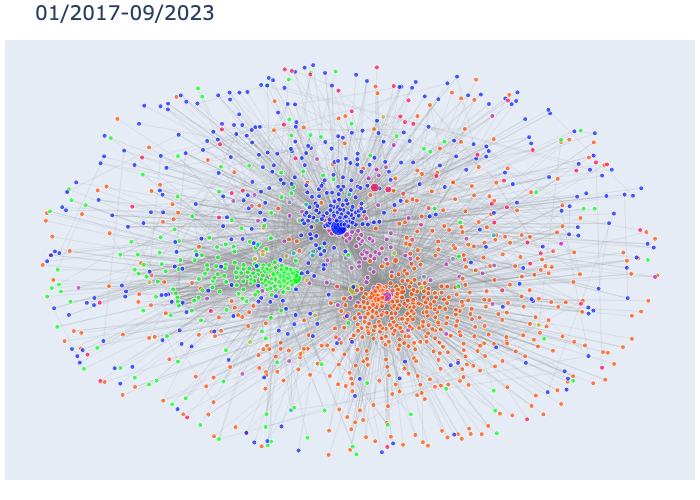

In [7]:
# write an image of the ecosystem for review. Above rendered figure doesn't appear in Github review.
ecosystem_g_figure.write_image("wasm_ecosystem.png")
Image(filename="wasm_ecosystem.png")

## Network Interpretation:

Each 'dot' in the network is a contributor. 

The size and location of each node is indicative of that contributor's pagerank-centrality in the overall collaboration network.

The edges between nodes represent the existence of a relationship- two contributors that participated in the same issue message thread, reviewing each other's PRs, etc.

Node color is indicative of the repositories that a given node has participated in. For instance, each individual repo is assigned its own distinct color. If a contributor participates in only one repo, their node color will be identical to the repo's color. If a contributor participates in more than one repo, the color of the contirbutor's node is the average of the colors of the repo they participate in.

Process the network, counting the number of nodes per repo overlap category to see where largest overlaps are.

TODO: Colors for the histogram below should be inherited from network above, unsure why they're not.

In [8]:
origin_colors = {}
origin_counts = {}

for node in ecosystem_g.nodes:

    # tri-tuple of RGB
    origin = ecosystem_g.nodes[node]['origin']
    color = ecosystem_g.nodes[node]['color']

    if origin not in origin_colors:
        origin_colors[origin] = color
    
    if origin not in origin_counts:
        origin_counts[origin] = 1
    else:
        origin_counts[origin] += 1

# sort by size of overlap
origin_counts = sorted([(key, val) for key, val in origin_counts.items()], key=lambda x: x[1])

# reorder colors by origin value
origin_colors = [origin_colors[origin_val[0]] for origin_val in origin_counts]
df_overlap = pd.DataFrame(origin_counts, columns=["repos", "size_overlap"])

Draw histogram. Represents size of populations in respective collaboration overlap, e.g. at time of writing, 85 contributors had made contributions to wasmtime+wasmer. 

These counts don't consider contribution quality- a contributor could land in the 'wasmer+wasmtime' pile for a single issue they authored in 2017. This is an area of future work.

In [9]:
px_overlap_frequency = px.bar(df_overlap, x='repos', y='size_overlap', color=origin_colors)
px_overlap_frequency.update_layout(showlegend=False)
px_overlap_frequency.write_image("wasm_histogram.png")
px_overlap_frequency

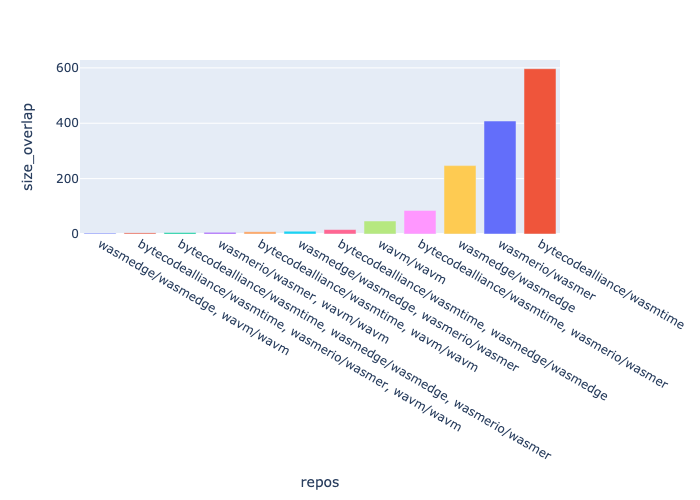

In [10]:
Image(filename="wasm_histogram.png")

## Summary of Findings:

This notebook is not answering to a particular hypothesis- we are developing this technology as background for future work. However, the above results are good candidates for inspection because they summarize an intuitively sensible finding.

The network being considered is a raw collaboration network between people across four communities. The histogram following highlights the populations of contributors conditioned on their historical contribution breadth- WHO has contributed WHERE, naively.

We see that, for the majority of contributors, only one project receives attention. There are noticable linchpin contributors in the network that connect WASMTime+WASMEdge, or WASMTime, WASMer, and WAVM, but most contributors participate in only one project.

Further study might answer the question of inter-project collaboration quality: for those people who participate in more than one project, are they doing so in the same way? Are those who are influential in one community more likely to be influential in another?

## Key take-away:

Among the projects studied, there are minor overlaps on contributorship with some noteable linchpins, but even considering collaboration back to 2017, the projects are relatively siloed.

## Suggested questions for future work:

1. Are the repos studied connected semantically by purpose? If they're in the WASM domain but aren't actually used together in practice (some being Browser WASM while others are serverside) then they'd obviously be fairly disconnected. Could be fertile ground for a project discovery phase- where are the contributors to the known projects also contributing? What does that 2nd round collaboration network reveal about collaboration densities between projects?

2. How high-quality are the edges that connect two projects by the proxy of contributor collaboration? If the correspondence is mostly in issue threads, for instance, these lower-impact edges insinuate communication, but don't directly imply technical collaboration or idea sharing.

    2.1. If we track this network over time, we could identify a new project that has a high existing-contributor migration signal. This new project, which is inheriting interest from existing contributors, could be very interesting in its ecosystem. We could identify this project by considering anomylous edge creation. 


3. How strong are project walls? e.g. to what extent do contributors, when clustered empirically, map to a single project versus a cluster that represents multiple projects? If an unsupervised 'n' clustering on the network of 'n' projects yields weak overlap, or significantly better clustering for 'n-m' clusters, this suggests that the collaboration space is in a higher-level embedding (to abuse the term) than repo-level.